In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [3]:
include("src/spiking.jl")
include("src/vsa.jl")

similarity_outer (generic function with 2 methods)

In [4]:
using Plots

In [5]:
n_x = 101
n_y = 101
n_vsa = 1

1

In [6]:
repeats = 6

6

In [7]:
phase_x = reshape(range(-1.0, 1.0, n_x), (1, n_x, n_vsa)) |> collect
phase_y = reshape(range(-1.0, 1.0, n_y), (1, n_y, n_vsa)) |> collect

1×101×1 Array{Float64, 3}:
[:, :, 1] =
 -1.0  -0.98  -0.96  -0.94  -0.92  -0.9  …  0.9  0.92  0.94  0.96  0.98  1.0

In [8]:
sims = similarity_outer(phase_x, phase_y, 2)[1,1,:,:]

101×101 Matrix{Float64}:
 1.0       0.998027  0.992115  0.982287  …  0.992115  0.998027  1.0
 0.998027  1.0       0.998027  0.992115     0.982287  0.992115  0.998027
 0.992115  0.998027  1.0       0.998027     0.968583  0.982287  0.992115
 0.982287  0.992115  0.998027  1.0          0.951057  0.968583  0.982287
 0.968583  0.982287  0.992115  0.998027     0.929776  0.951057  0.968583
 0.951057  0.968583  0.982287  0.992115  …  0.904827  0.929776  0.951057
 0.929776  0.951057  0.968583  0.982287     0.876307  0.904827  0.929776
 0.904827  0.929776  0.951057  0.968583     0.844328  0.876307  0.904827
 0.876307  0.904827  0.929776  0.951057     0.809017  0.844328  0.876307
 0.844328  0.876307  0.904827  0.929776     0.770513  0.809017  0.844328
 ⋮                                       ⋱                      ⋮
 0.876307  0.844328  0.809017  0.770513     0.929776  0.904827  0.876307
 0.904827  0.876307  0.844328  0.809017     0.951057  0.929776  0.904827
 0.929776  0.904827  0.876307  0.84432

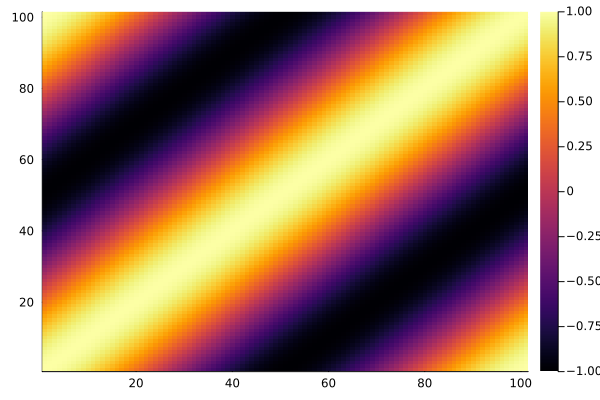

In [9]:
heatmap(sims)

In [10]:
spk_args = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [11]:
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [12]:
st_x = phase_to_train(phase_x, spk_args, repeats = repeats)
st_y = phase_to_train(phase_y, spk_args, repeats = repeats)

Spike Train: (1, 101, 1) with 606 spikes.

In [13]:
sims_2 = similarity_outer(st_x, st_y, 2);

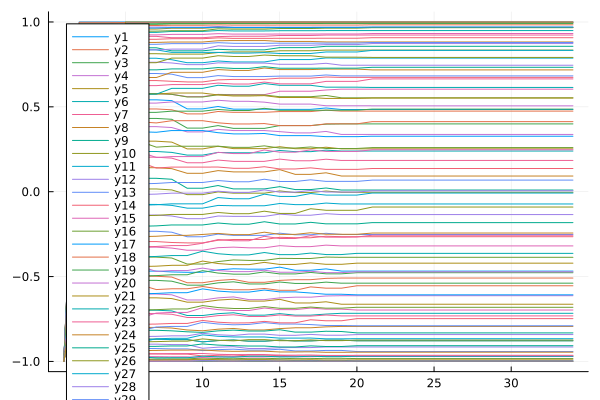

In [14]:
plot(sims_2[1,1,1:30:end,1,:])

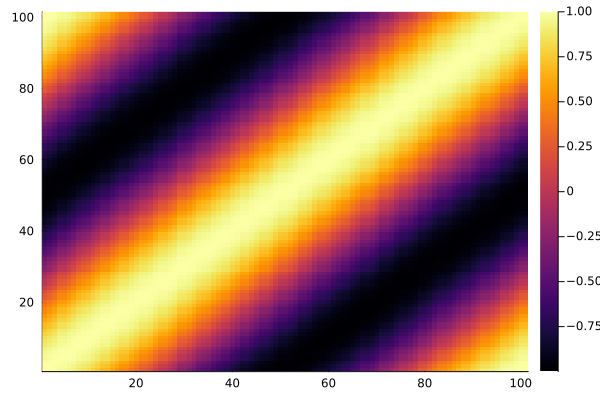

In [15]:
heatmap(sims_2[1,1,end,:,:])

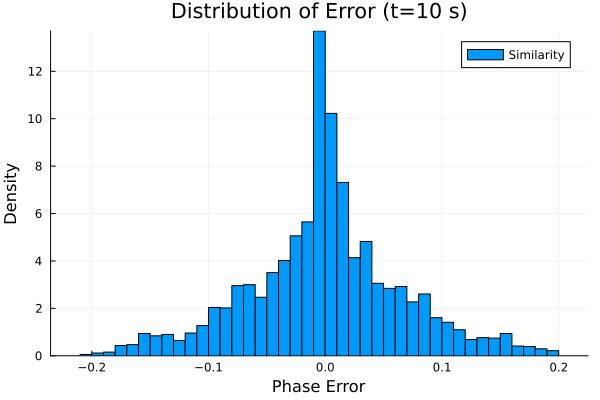

In [21]:
fig = histogram((pi .* vec(sims_2[1,1,end,:,:] .- sims)), label="Similarity", normalize=:pdf)
xlabel!("Phase Error")
ylabel!("Density")
title!("Distribution of Error (t=10 s)")

In [22]:
png(fig, "sim phase error.png")

"sim phase error.png"

In [17]:
errors = [mean(vec(sims_2[1,1,i,:,:] .- sims)) for i in axes(sims_2,3)]

1001-element Vector{Float64}:
 -1.0000980296049407
 -0.9799043184004914
 -0.9695151169433209
 -0.9481559187792961
 -0.937188237542008
 -0.9260345367346777
 -0.9260345367349254
 -0.9147207264047127
 -0.9032370537961598
 -0.8797464247568101
  ⋮
 -3.48860355672515e-6
 -3.4865783210255438e-6
 -3.4929487214771142e-6
 -3.501523251279504e-6
 -3.4887128963144232e-6
 -3.4859473308557586e-6
 -3.4931618069445413e-6
 -3.4940707226745406e-6
 -3.487978768505068e-6

In [23]:
fig = plot(0:0.01:10, abs.(errors), label="Similarity")
ylabel!("Mean Error")
xlabel!("Time (s)")
title!("Error by Time")
png(fig, "sim time error.png")

"sim time error.png"

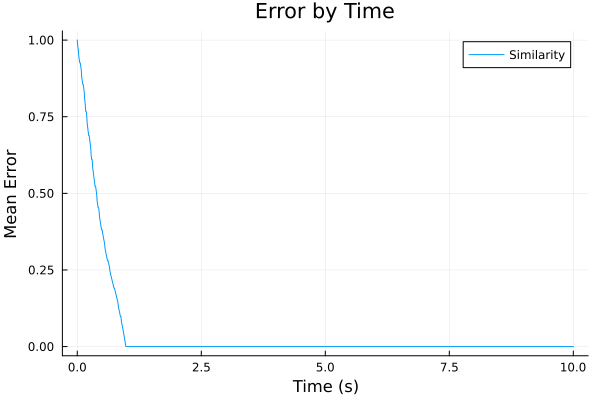

In [24]:
fig

In [6]:
phase_x = random_symbols((n_vsa, 1));

In [7]:
phase_z = random_symbols((n_vsa, 3));

In [8]:
phase_xp = random_symbols((n_vsa, 1));

In [9]:
phase_y = reduce(hcat, collect(range(start=phase_x, stop=phase_xp, length=n_y)));

In [10]:
sims = similarity(phase_x, phase_y)

1×10 Matrix{Float64}:
 1.0  0.961611  0.853221  0.693595  …  0.065888  0.0047556  -0.013237

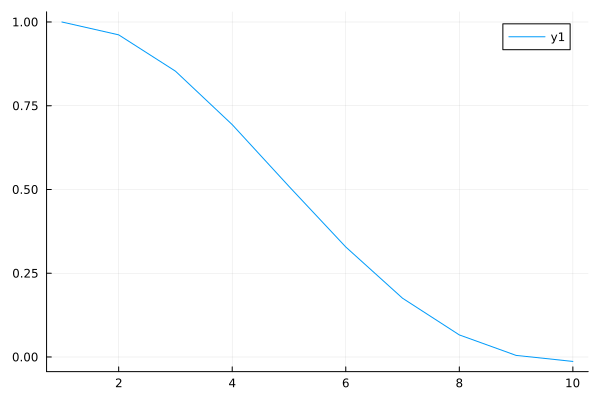

In [11]:
plot(sims |> vec)

In [12]:
similarity_self(phase_z, 2)

1×3×3 Array{Float64, 3}:
[:, :, 1] =
 1.0  -0.0223828  0.00467365

[:, :, 2] =
 -0.0223828  1.0  0.0315101

[:, :, 3] =
 0.00467365  0.0315101  1.0

In [ ]:
st_x = phase_to_train(phase_x, spk_args, repeats = repeats)
st_y = phase_to_train(phase_y, spk_args, repeats = repeats)

Spike Train: (512, 10) with 30720 spikes.

In [16]:
using OrdinaryDiffEq

In [17]:
sa = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [18]:
function similarity(x::SpikeTrain, y::SpikeTrain, dim::Int = 1; tspan::Tuple{<:Real, <:Real} = (0.0, 10.0), spk_args::SpikingArgs = default_spk_args(), return_solution::Bool = false)
    sol_x = phase_memory(x, tspan = tspan, spk_args = spk_args)
    sol_y = phase_memory(y, tspan = tspan, spk_args = spk_args)

    
    u_x = normalize_potential.(Array(sol_x))
    u_y = normalize_potential.(Array(sol_y))

    interference = u_x .+ u_y
    magnitude = clamp.(abs.(interference), 0.0, 2.0)
    half_angle = acos.(0.5 .* magnitude)
    sim = cos.(2.0 .* half_angle)
    avg_sim = mean(sim, dims=dim)
    
    return avg_sim

end

similarity (generic function with 3 methods)

In [19]:
sim = similarity(st_x, st_y, 1, tspan=tspan, spk_args=sa, return_solution=true);

In [20]:
sim

1×10×601 Array{Float64, 3}:
[:, :, 1] =
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0

[:, :, 2] =
 -0.957031  -0.986328  -0.986328  …  -0.988281  -0.987305  -0.978516

[:, :, 3] =
 -0.925781  -0.972658  -0.974609  …  -0.974616  -0.971687  -0.964844

;;; … 

[:, :, 599] =
 1.0  0.961085  0.85204  0.691923  …  0.0656402  0.00527369  -0.012873

[:, :, 600] =
 1.0  0.96107  0.852012  0.69189  …  0.0656426  0.00528372  -0.0128958

[:, :, 601] =
 1.0  0.961047  0.851973  0.691844  …  0.0656409  0.00528843  -0.0128995

In [21]:
sim |> size

(1, 10, 601)

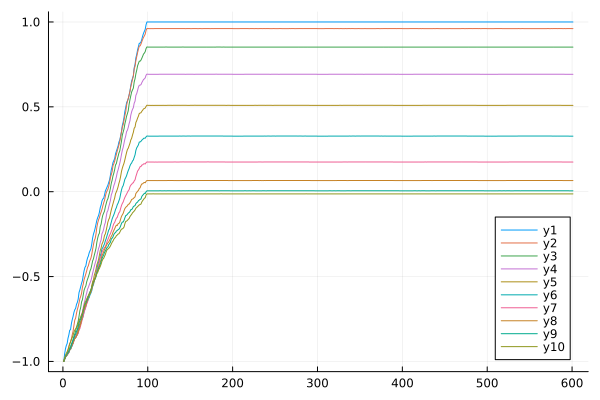

In [22]:
plot(sim[1,:,:]')

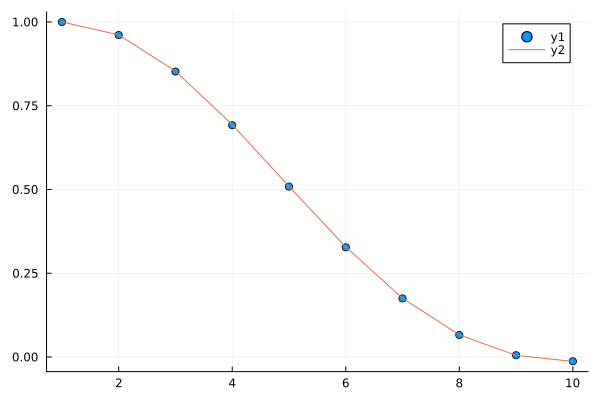

In [23]:
scatter(sim[1,:,end])
plot!(sims |> vec)

In [24]:
spk_sim = sim[1,:,end]

10-element Vector{Float64}:
  0.9999999683350331
  0.9610471370921649
  0.8519726173343136
  0.6918441552196789
  0.508650481623056
  0.32738948291300696
  0.1747629498774072
  0.06564085418411421
  0.00528843025936188
 -0.012899495518742716

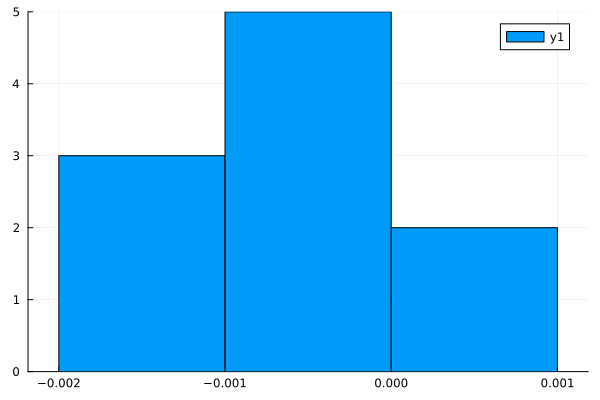

In [25]:
error = spk_sim .- vec(sims)
histogram(error)